In [12]:
# Create suboptimal and optimal policies
# Train the critics for these policies using FQI
# Aplly safe learning using our strategy for switching between the two policies

In [1]:
import datetime
import os
import pprint

import numpy as np
from tianshou.data.buffer.vecbuf import VectorReplayBuffer, ReplayBuffer
from tianshou.env.venvs import SubprocVectorEnv
import torch
from torch import nn
from copy import deepcopy
from torch.utils.tensorboard import SummaryWriter
from env.risky_pointmass import PointMass
import matplotlib.pyplot as plt

from tianshou.data import Collector, Batch, to_torch
from tianshou.data.types import RolloutBatchProtocol
from tianshou.policy import DSACPolicy, BasePolicy, SACPolicy
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
from tianshou.utils.net.continuous import ActorProb, QuantileMlp, Critic

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 303, in register_gymnasium_envs
    _register_dm_control_envs()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 63, in _register_dm_control_envs
    from shimmy.dm_control_compatibility import DmControlCompatibilityV0
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shim

In [2]:
task = "PointMass"
seed = 0
risk_type = "wang"
buffer_size = 1000000
hidden_sizes = [256, 256, 256]
actor_lr = 3e-4
critic_lr = 3e-4
gamma = 0.99
tau = 0.005
alpha = 0.02
auto_alpha = False
exploration = True
alpha_lr = 3e-4
start_timesteps = 10000
epoch = 100
step_per_epoch = 500
step_per_collect = 1
update_per_step = 1
n_step = 1
batch_size = 256
training_num = 10
test_num = 1
logdir = "log"
device = "cuda:2"

In [3]:
distortion_param = 0.75
risk_penalty = 100
risk_prob = 0.95
high_state = 1.5
env = PointMass(risk_penalty=risk_penalty, risk_prob=risk_prob, high_state=high_state)

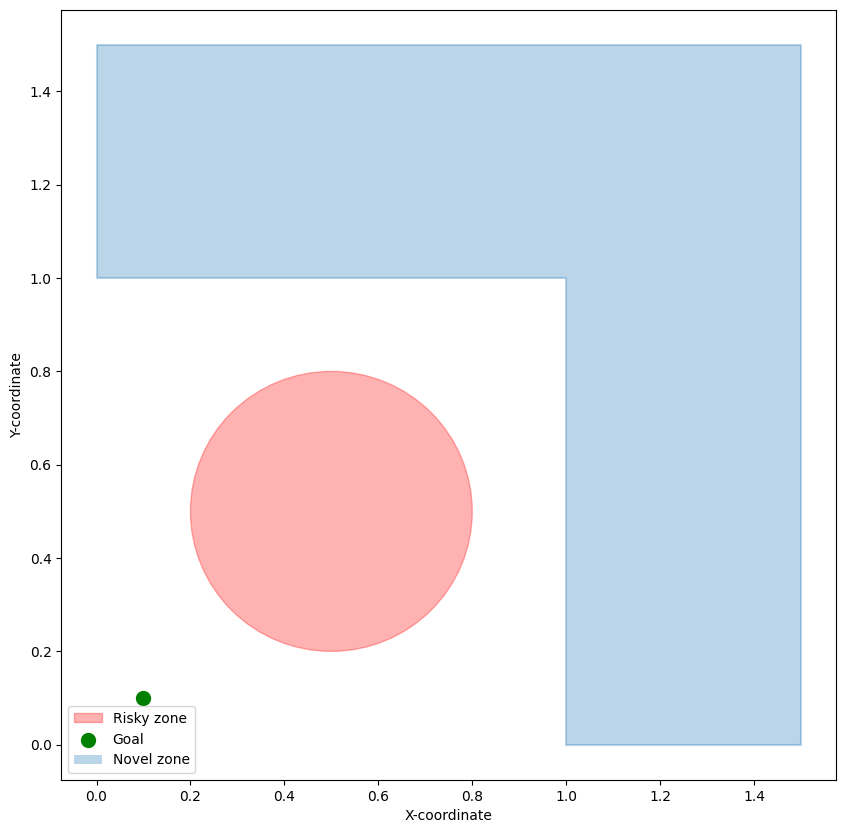

In [4]:
# Create a figure for plotting
plt.figure(figsize=(10, 10))

x = [1, 1, 0, 0, 1.5, 1.5, 1]  
y = [0, 1, 1, 1.5, 1.5, 0, 0]

# Plot the risk area
circle = plt.Circle(env.center, 0.3, color='red', alpha=0.3, label='Risky zone')
plt.gca().add_patch(circle)

# Plot the goal
plt.scatter(*env.goal, color='green', marker='o', s=100, label='Goal')
plt.plot(x, y, alpha=0.3)
plt.fill(x, y, alpha=0.3, label='Novel zone')  

plt.legend()
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.show()  

In [5]:
state_shape = env.observation_space.shape or env.observation_space.n
action_shape = env.action_space.shape or env.action_space.n

In [6]:
def load_policy(path, distortion_param=distortion_param, alpha=alpha):
    net_a = Net(state_shape, hidden_sizes=hidden_sizes, device=device)
    actor = ActorProb(
        net_a,
        action_shape,
        device=device,
        unbounded=True,
        conditioned_sigma=True,
    ).to(device)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=actor_lr)

    critic1 = QuantileMlp(hidden_sizes=hidden_sizes, input_size=state_shape[0] + action_shape[0], device=device).to(device)
    critic1_optim = torch.optim.Adam(critic1.parameters(), lr=critic_lr)
    critic2 = QuantileMlp(hidden_sizes=hidden_sizes, input_size=state_shape[0] + action_shape[0], device=device).to(device)
    critic2_optim = torch.optim.Adam(critic2.parameters(), lr=critic_lr)

    policy = DSACPolicy(
        actor,
        actor_optim,
        critic1,
        critic1_optim,
        critic2,
        critic2_optim,
        risk_type=risk_type,
        tau=tau,
        gamma=gamma,
        alpha=alpha,
        estimation_step=n_step,
        action_space=env.action_space,
        distortion_param=distortion_param,
        device=device,
    )
    policy.load_state_dict(torch.load(path, map_location=device))
    print("Loaded agent from: ", path)
    return policy

In [7]:
def get_init_states(n=50, seed=None):
    if seed is not None:
        np.random.seed(seed)
    x_grid = np.linspace(0.4, 1.5, 101)
    y_grid = np.linspace(0.4, 1.5, 101)
    init_states = np.stack([(x, y) for x in x_grid for y in y_grid])
    init_states = np.array([(x, y) for x, y in init_states if np.linalg.norm(np.array((x,y))-env.center) > env.r])
    init_states = init_states[np.random.choice(len(init_states), n)]
    return init_states   

def plot_trajectories(policy):
    policy.eval()
    init_states = get_init_states()
    trajectories = []
    for state in init_states:
        obs, info = env.reset(init_state=state)
        done = False
        cum_reward = 0
        actions = []
        while not done:
            batch = Batch(obs=torch.from_numpy(np.expand_dims(obs, 0)).to(device), info=info)
            with torch.no_grad():
                result = policy(batch)
            act = result.act.cpu().squeeze().numpy()
            act = policy.map_action(act)
            obs, reward, terminated, truncated, info = env.step(act)
            actions.append(act)
            cum_reward += reward
            done = terminated or truncated 
        trajectories.append(env.trajectory)

    # Create a figure for plotting
    plt.figure(figsize=(10, 10))

    # Novel zone coordinates
    x = [1, 1, 0, 0, 1.5, 1.5, 1]  
    y = [0, 1, 1, 1.5, 1.5, 0, 0]

    # Plot the risk area
    circle = plt.Circle((0.5, 0.5), 0.3, color='red', alpha=0.3, label="Risk zone")
    plt.gca().add_patch(circle)

    # Plot the novel area
    plt.plot(x, y, alpha=0.3)
    plt.fill(x, y, alpha=0.3, label='Novel zone')  

    # Plot the goal
    plt.scatter(*env.goal, color='green', marker='o', s=100, label='Goal')

    # Plot the start states
    plt.scatter(*zip(*init_states), color='blue', marker='o', s=10, label='Start States')

    # Plot the trajectories
    for traj in trajectories:
        plt.plot(*zip(*traj), color='gray', linewidth=1, alpha=0.3)

    plt.legend()
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Trajectories from Start States to Goal')
    plt.show()      

Loaded agent from:  /data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20_hs1/dsac/wang-0.75/159/240111-105150/policy.pth


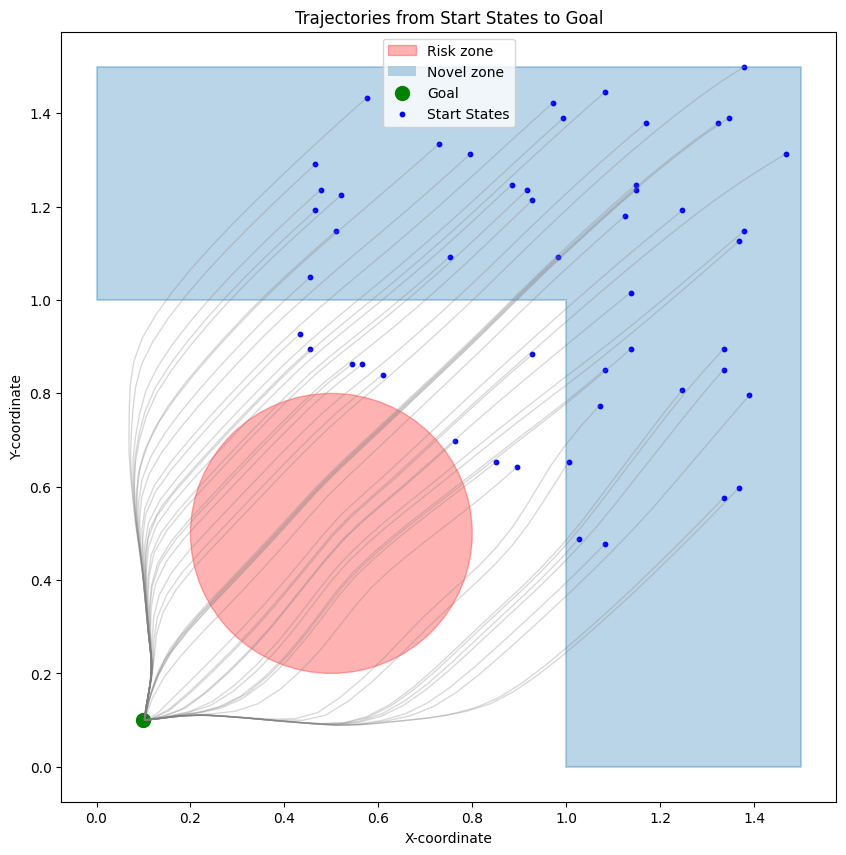

In [8]:
risky_policy_path = "/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20_hs1/dsac/wang-0.75/159/240111-105150/policy.pth"
risky_policy =  load_policy(risky_policy_path)
plot_trajectories(risky_policy)

# Create suboptimal policy:
### On the non novel part of the state space this policy will behave like a risky policy, and like a random policy on the novel part of the state space

In [9]:
class SubOptTeacher(BasePolicy):
    def __init__(self, risky_policy: BasePolicy, action_space):
        super().__init__(action_space=action_space, action_scaling=True)
        self.action_space = action_space
        self.risky_policy = risky_policy

    def is_novel(self, batch):
        return torch.max(batch.obs, dim=-1)[0] > 1
    
    def random_actions(self, batch):
        high = self.action_space.high
        low = self.action_space.low
        random_factors = np.random.uniform(0, 1, len(batch.obs)* np.prod(high.shape)).reshape(len(batch.obs), *(high.shape))
        return to_torch(low + (high - low) * random_factors, dtype=torch.float32, device=device)

    def forward(self, batch: RolloutBatchProtocol, state=None, **kwargs):
        batch = to_torch(batch, dtype=torch.float32, device=device)
        with torch.no_grad():
            result = self.risky_policy(batch)
        is_novel = self.is_novel(batch)
        random_actions = self.random_actions(batch)
        actions = torch.where(is_novel.unsqueeze(-1).expand_as(random_actions), random_actions, result.act)
        return Batch(**{'act': actions, 'policy': Batch()})
    
    def process_fn(self, batch: RolloutBatchProtocol, buffer: ReplayBuffer, indices: np.ndarray) -> RolloutBatchProtocol:
        return self.risky_policy.process_fn(batch, buffer, indices)

    def learn(self, batch, **kwargs):
        return {}

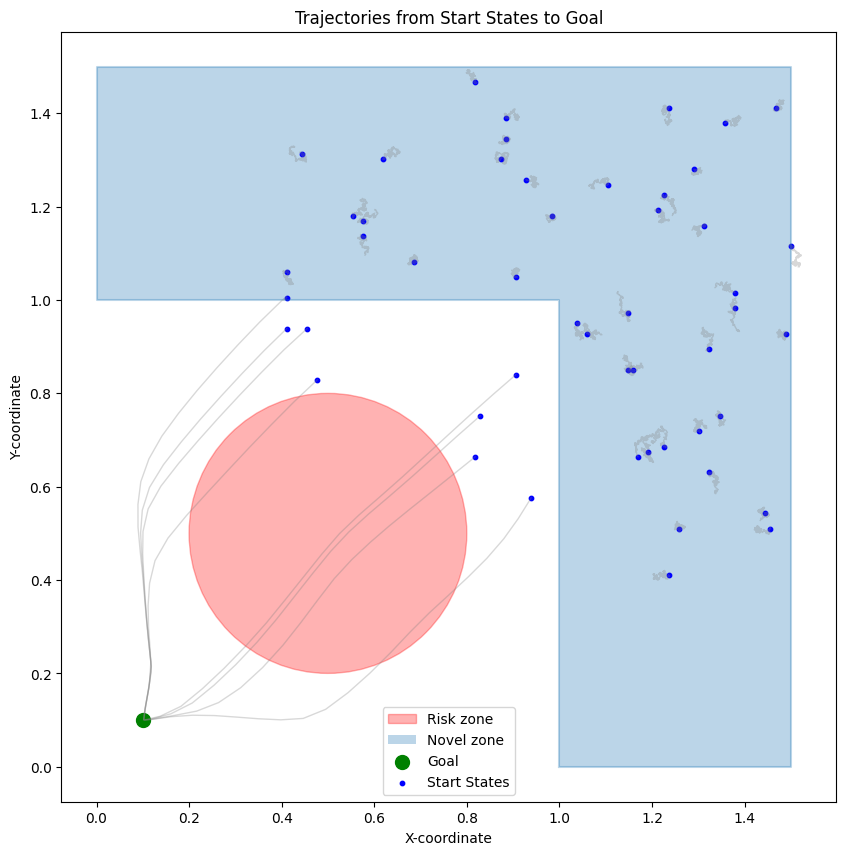

In [10]:
teacher = SubOptTeacher(risky_policy, env.action_space)
plot_trajectories(teacher)

### Learn the suboptimal policy

In [12]:
class SubOptStudent(SACPolicy):
    def __init__(self, 
        actor: torch.nn.Module,
        actor_optim: torch.optim.Optimizer,
        critic1: torch.nn.Module,
        critic1_optim: torch.optim.Optimizer,
        critic2: torch.nn.Module,
        critic2_optim: torch.optim.Optimizer,
        action_space,
        mode):
        super().__init__(actor, actor_optim, critic1, critic1_optim, critic2, critic2_optim, action_space=action_space, action_scaling=True)
        self.mode = mode

    def learn(self, batch, **kwargs):
        batch = to_torch(batch, dtype=torch.float32, device=device)
        if self.mode == "sac":
            return super().learn(batch, **kwargs)
        elif self.mode == "cloning":
            # actor
            self.actor_optim.zero_grad()
            pred = self(batch)
            loss = torch.mean((pred.act - batch.act) ** 2)
            loss.backward()
            self.actor_optim.step()
            return {"loss/actor": loss.item()}
        else:
            raise NotImplementedError("This optionn is not implemented.")

In [13]:
net_a = Net(state_shape, hidden_sizes=hidden_sizes, device=device)
actor = ActorProb(
    net_a,
    action_shape,
    device=device,
    unbounded=True,
    conditioned_sigma=True,
).to(device)
actor_optim = torch.optim.Adam(actor.parameters(), lr=actor_lr)

net_c1 = Net(
    state_shape,
    action_shape,
    hidden_sizes=hidden_sizes,
    concat=True,
    device=device,
    norm_layer=nn.LayerNorm
)
net_c2 = Net(
    state_shape,
    action_shape,
    hidden_sizes=hidden_sizes,
    concat=True,
    device=device,
    norm_layer=nn.LayerNorm
)
critic1 = Critic(net_c1, device=device).to(device)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=critic_lr)
critic2 = Critic(net_c2, device=device).to(device)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=critic_lr)

student = SubOptStudent(
    actor,
    actor_optim,
    critic1,
    critic1_optim,
    critic2,
    critic2_optim,
    action_space=env.action_space,
    mode="cloning")

In [17]:
# envs 
train_envs = SubprocVectorEnv([lambda: PointMass(risk_penalty=risk_penalty, risk_prob=risk_prob, high_state=high_state) for _ in range(training_num)])
test_envs = SubprocVectorEnv([lambda: PointMass(risk_penalty=risk_penalty, risk_prob=risk_prob, high_state=high_state) for _ in range(test_num)])

# collector
buffer = VectorReplayBuffer(buffer_size, training_num)
train_collector = Collector(teacher, train_envs, buffer)
test_collector = Collector(student, test_envs)

In [ ]:
# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
algo_name = "imitation"
log_name = os.path.join(task+f"_prob{risk_prob}"+f"_pen{risk_penalty}"+f"_hs{high_state}", algo_name, str(seed), now)
log_path = os.path.join(logdir, log_name)
print(f"log path: {log_path}")

# logger
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

log path: log/PointMass_prob0.95_pen100_hs1.5/imitation/0/240115-133331


In [ ]:
def save_best_fn(policy):
    torch.save(policy.state_dict(), os.path.join(log_path, "best.pth"))

def test_fn(num_epoch: int, step_idx: int):
    torch.save(student.state_dict(), os.path.join(log_path, "policy.pth"))

In [ ]:
result = OffpolicyTrainer(
    policy=student,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=epoch,
    step_per_epoch=step_per_epoch,
    step_per_collect=step_per_collect,
    episode_per_test=test_num,
    batch_size=batch_size,
    save_best_fn=save_best_fn,
    test_fn=test_fn,
    logger=logger,
    update_per_step=update_per_step,
    test_in_train=False,
).run()
pprint.pprint(result)

Epoch #1: 501it [00:03, 158.79it/s, env_step=500, gradient_step=500, len=11, loss/actor=0.005, n/ep=0, n/st=10, rew=-2.54]                         


Epoch #1: test_reward: -55.273152 ± 0.000000, best_reward: -55.273152 ± 0.000000 in #1


Epoch #2: 501it [00:03, 160.05it/s, env_step=1000, gradient_step=1000, len=11, loss/actor=0.002, n/ep=0, n/st=10, rew=-2.54]                         


Epoch #2: test_reward: -1369.706636 ± 0.000000, best_reward: -55.273152 ± 0.000000 in #1


Epoch #3: 501it [00:02, 167.48it/s, env_step=1500, gradient_step=1500, len=11, loss/actor=0.001, n/ep=0, n/st=10, rew=-2.54]                         


Epoch #3: test_reward: -347.706986 ± 0.000000, best_reward: -55.273152 ± 0.000000 in #1


Epoch #4: 501it [00:03, 164.43it/s, env_step=2000, gradient_step=2000, len=200, loss/actor=0.001, n/ep=5, n/st=10, rew=-261.94]                         


Epoch #4: test_reward: -1276.224328 ± 0.000000, best_reward: -55.273152 ± 0.000000 in #1


Epoch #5: 501it [00:03, 155.75it/s, env_step=2500, gradient_step=2500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-285.21]                         


Epoch #5: test_reward: -32.780476 ± 0.000000, best_reward: -32.780476 ± 0.000000 in #5


Epoch #6: 501it [00:03, 155.39it/s, env_step=3000, gradient_step=3000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-285.21]                         


Epoch #6: test_reward: -35.320825 ± 0.000000, best_reward: -32.780476 ± 0.000000 in #5


Epoch #7: 501it [00:03, 159.28it/s, env_step=3500, gradient_step=3500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-285.21]                         


Epoch #7: test_reward: -302.391293 ± 0.000000, best_reward: -32.780476 ± 0.000000 in #5


Epoch #8: 501it [00:03, 158.89it/s, env_step=4000, gradient_step=4000, len=200, loss/actor=0.001, n/ep=5, n/st=10, rew=-253.84]                         


Epoch #8: test_reward: -4.657988 ± 0.000000, best_reward: -4.657988 ± 0.000000 in #8


Epoch #9: 501it [00:03, 157.05it/s, env_step=4500, gradient_step=4500, len=18, loss/actor=0.001, n/ep=0, n/st=10, rew=-7.90]                            


Epoch #9: test_reward: -318.038240 ± 0.000000, best_reward: -4.657988 ± 0.000000 in #8


Epoch #10: 501it [00:03, 152.27it/s, env_step=5000, gradient_step=5000, len=18, loss/actor=0.001, n/ep=0, n/st=10, rew=-7.90]                         


Epoch #10: test_reward: -338.149404 ± 0.000000, best_reward: -4.657988 ± 0.000000 in #8


Epoch #11: 501it [00:03, 163.79it/s, env_step=5500, gradient_step=5500, len=18, loss/actor=0.001, n/ep=0, n/st=10, rew=-7.90]                         


Epoch #11: test_reward: -43.838211 ± 0.000000, best_reward: -4.657988 ± 0.000000 in #8


Epoch #12: 501it [00:03, 161.06it/s, env_step=6000, gradient_step=6000, len=200, loss/actor=0.001, n/ep=3, n/st=10, rew=-287.11]                         


Epoch #12: test_reward: 0.446219 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #13: 501it [00:02, 167.18it/s, env_step=6500, gradient_step=6500, len=17, loss/actor=0.001, n/ep=1, n/st=10, rew=-8.85]                            


Epoch #13: test_reward: -9.378864 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #14: 501it [00:02, 167.96it/s, env_step=7000, gradient_step=7000, len=8, loss/actor=0.001, n/ep=0, n/st=10, rew=-0.82]                          


Epoch #14: test_reward: -7.220953 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #15: 501it [00:02, 168.55it/s, env_step=7500, gradient_step=7500, len=8, loss/actor=0.001, n/ep=0, n/st=10, rew=-0.82]                         


Epoch #15: test_reward: -153.657002 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #16: 501it [00:02, 167.37it/s, env_step=8000, gradient_step=8000, len=200, loss/actor=0.001, n/ep=2, n/st=10, rew=-343.46]                         


Epoch #16: test_reward: -296.605200 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #17: 501it [00:03, 166.13it/s, env_step=8500, gradient_step=8500, len=18, loss/actor=0.001, n/ep=0, n/st=10, rew=-9.22]                            

Epoch #17: test_reward: 0.089702 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12



Epoch #18: 501it [00:03, 161.87it/s, env_step=9000, gradient_step=9000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-251.13]                         


Epoch #18: test_reward: -284.695600 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #19: 501it [00:03, 159.70it/s, env_step=9500, gradient_step=9500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-251.13]                         


Epoch #19: test_reward: -13.018521 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #20: 501it [00:03, 158.99it/s, env_step=10000, gradient_step=10000, len=200, loss/actor=0.001, n/ep=1, n/st=10, rew=-226.58]                         


Epoch #20: test_reward: -263.246990 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #21: 501it [00:03, 163.23it/s, env_step=10500, gradient_step=10500, len=16, loss/actor=0.001, n/ep=0, n/st=10, rew=-6.05]                            


Epoch #21: test_reward: -225.660415 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #22: 501it [00:03, 157.81it/s, env_step=11000, gradient_step=11000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-327.51]                         


Epoch #22: test_reward: -293.033220 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #23: 501it [00:03, 157.61it/s, env_step=11500, gradient_step=11500, len=14, loss/actor=0.001, n/ep=0, n/st=10, rew=-4.35]                         


Epoch #23: test_reward: -10.819862 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #24: 501it [00:03, 156.42it/s, env_step=12000, gradient_step=12000, len=200, loss/actor=0.001, n/ep=1, n/st=10, rew=-291.48]                         


Epoch #24: test_reward: -3.625094 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #25: 501it [00:03, 155.46it/s, env_step=12500, gradient_step=12500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-295.72]                         


Epoch #25: test_reward: -363.478953 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #26: 501it [00:03, 155.89it/s, env_step=13000, gradient_step=13000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-337.39]                         


Epoch #26: test_reward: -56.716585 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #27: 501it [00:03, 156.07it/s, env_step=13500, gradient_step=13500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-262.94]                         


Epoch #27: test_reward: -9.122629 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #28: 501it [00:03, 153.20it/s, env_step=14000, gradient_step=14000, len=200, loss/actor=0.001, n/ep=1, n/st=10, rew=-225.15]                         


Epoch #28: test_reward: -254.975829 ± 0.000000, best_reward: 0.446219 ± 0.000000 in #12


Epoch #29: 501it [00:03, 146.71it/s, env_step=14500, gradient_step=14500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-302.08]                         


Epoch #29: test_reward: 0.640578 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #30: 501it [00:03, 156.14it/s, env_step=15000, gradient_step=15000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-296.92]                         


Epoch #30: test_reward: -107.940347 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #31: 501it [00:03, 157.45it/s, env_step=15500, gradient_step=15500, len=13, loss/actor=0.001, n/ep=0, n/st=10, rew=-3.82]                           

Epoch #31: test_reward: 0.052176 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29



Epoch #32: 501it [00:03, 150.33it/s, env_step=16000, gradient_step=16000, len=200, loss/actor=0.001, n/ep=1, n/st=10, rew=-248.92]                         


Epoch #32: test_reward: -2.355508 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #33: 501it [00:03, 149.42it/s, env_step=16500, gradient_step=16500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-283.50]                         


Epoch #33: test_reward: -285.843020 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #34: 501it [00:03, 148.11it/s, env_step=17000, gradient_step=17000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-285.27]                         


Epoch #34: test_reward: -331.145215 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #35: 501it [00:03, 161.85it/s, env_step=17500, gradient_step=17500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-346.03]                         


Epoch #35: test_reward: -346.256465 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #36: 501it [00:03, 163.94it/s, env_step=18000, gradient_step=18000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-346.03]                         


Epoch #36: test_reward: -222.459933 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #37: 501it [00:03, 164.10it/s, env_step=18500, gradient_step=18500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-319.11]                         


Epoch #37: test_reward: -286.958366 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #38: 501it [00:03, 147.80it/s, env_step=19000, gradient_step=19000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-303.06]                         


Epoch #38: test_reward: -2.686889 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #39: 501it [00:03, 148.15it/s, env_step=19500, gradient_step=19500, len=100, loss/actor=0.001, n/ep=0, n/st=10, rew=-110.89]                         


Epoch #39: test_reward: -264.849128 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #40: 501it [00:03, 164.44it/s, env_step=20000, gradient_step=20000, len=100, loss/actor=0.001, n/ep=0, n/st=10, rew=-110.89]                         


Epoch #40: test_reward: -224.659987 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #41: 501it [00:03, 157.64it/s, env_step=20500, gradient_step=20500, len=14, loss/actor=0.001, n/ep=0, n/st=10, rew=-4.83]                            


Epoch #41: test_reward: -333.161935 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #42: 501it [00:03, 141.44it/s, env_step=21000, gradient_step=21000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-386.86]                         


Epoch #42: test_reward: -358.024628 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #43: 501it [00:03, 137.25it/s, env_step=21500, gradient_step=21500, len=19, loss/actor=0.001, n/ep=0, n/st=10, rew=-8.60]                            


Epoch #43: test_reward: -296.041154 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #44: 501it [00:03, 149.42it/s, env_step=22000, gradient_step=22000, len=18, loss/actor=0.001, n/ep=0, n/st=10, rew=-8.22]                         


Epoch #44: test_reward: -2.412419 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #45: 501it [00:03, 139.05it/s, env_step=22500, gradient_step=22500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-262.81]                         


Epoch #45: test_reward: -284.454213 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #46: 501it [00:03, 158.51it/s, env_step=23000, gradient_step=23000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-301.32]                         


Epoch #46: test_reward: -1.582339 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #47: 501it [00:03, 145.43it/s, env_step=23500, gradient_step=23500, len=4, loss/actor=0.001, n/ep=0, n/st=10, rew=0.30]                              


Epoch #47: test_reward: -271.767640 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #48: 501it [00:03, 151.78it/s, env_step=24000, gradient_step=24000, len=16, loss/actor=0.001, n/ep=0, n/st=10, rew=-5.77]                            


Epoch #48: test_reward: -3.626212 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #49: 501it [00:03, 160.40it/s, env_step=24500, gradient_step=24500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-230.09]                         


Epoch #49: test_reward: -390.482679 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #50: 501it [00:03, 156.69it/s, env_step=25000, gradient_step=25000, len=18, loss/actor=0.001, n/ep=0, n/st=10, rew=-9.08]                            


Epoch #50: test_reward: -2.613234 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #51: 501it [00:03, 145.66it/s, env_step=25500, gradient_step=25500, len=14, loss/actor=0.001, n/ep=0, n/st=10, rew=-4.55]                            


Epoch #51: test_reward: -260.322608 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #52: 501it [00:03, 149.05it/s, env_step=26000, gradient_step=26000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-282.23]                         


Epoch #52: test_reward: -6.121947 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #53: 501it [00:03, 151.99it/s, env_step=26500, gradient_step=26500, len=2, loss/actor=0.001, n/ep=0, n/st=10, rew=0.74]                              


Epoch #53: test_reward: -331.344827 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #54: 501it [00:03, 135.10it/s, env_step=27000, gradient_step=27000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-274.18]                         


Epoch #54: test_reward: -300.962813 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #55: 501it [00:03, 151.92it/s, env_step=27500, gradient_step=27500, len=10, loss/actor=0.001, n/ep=0, n/st=10, rew=-1.87]                            


Epoch #55: test_reward: -3.128160 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #56: 501it [00:03, 141.53it/s, env_step=28000, gradient_step=28000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-283.16]                         


Epoch #56: test_reward: -312.139863 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #57: 501it [00:03, 155.75it/s, env_step=28500, gradient_step=28500, len=13, loss/actor=0.001, n/ep=1, n/st=10, rew=-3.64]                            


Epoch #57: test_reward: -5.451575 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #58: 501it [00:03, 154.08it/s, env_step=29000, gradient_step=29000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-338.14]                         


Epoch #58: test_reward: -323.163585 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #59: 501it [00:03, 130.11it/s, env_step=29500, gradient_step=29500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-252.86]                         


Epoch #59: test_reward: -280.725155 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #60: 501it [00:03, 150.37it/s, env_step=30000, gradient_step=30000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-262.48]                         


Epoch #60: test_reward: -309.248474 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #61: 501it [00:03, 159.47it/s, env_step=30500, gradient_step=30500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-273.95]                         


Epoch #61: test_reward: -281.020876 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #62: 501it [00:03, 153.95it/s, env_step=31000, gradient_step=31000, len=18, loss/actor=0.001, n/ep=0, n/st=10, rew=-7.64]                            

Epoch #62: test_reward: -9.330254 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29



Epoch #63: 501it [00:03, 147.56it/s, env_step=31500, gradient_step=31500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-382.81]                         


Epoch #63: test_reward: -1.273927 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #64: 501it [00:03, 155.81it/s, env_step=32000, gradient_step=32000, len=8, loss/actor=0.001, n/ep=0, n/st=10, rew=-1.08]                             


Epoch #64: test_reward: -304.995961 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #65: 501it [00:03, 157.11it/s, env_step=32500, gradient_step=32500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-296.47]                         


Epoch #65: test_reward: -296.224214 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #66: 501it [00:03, 153.99it/s, env_step=33000, gradient_step=33000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-242.13]                         


Epoch #66: test_reward: 0.624675 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #67: 501it [00:03, 156.75it/s, env_step=33500, gradient_step=33500, len=17, loss/actor=0.001, n/ep=0, n/st=10, rew=-7.21]                            


Epoch #67: test_reward: -342.192520 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #68: 501it [00:03, 158.52it/s, env_step=34000, gradient_step=34000, len=14, loss/actor=0.001, n/ep=0, n/st=10, rew=-4.48]                            


Epoch #68: test_reward: -275.350375 ± 0.000000, best_reward: 0.640578 ± 0.000000 in #29


Epoch #69: 501it [00:03, 157.28it/s, env_step=34500, gradient_step=34500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-338.03]                         


Epoch #69: test_reward: 0.763578 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #70: 501it [00:03, 155.56it/s, env_step=35000, gradient_step=35000, len=15, loss/actor=0.001, n/ep=0, n/st=10, rew=-6.55]                            


Epoch #70: test_reward: 0.575063 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #71: 501it [00:03, 161.69it/s, env_step=35500, gradient_step=35500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-294.08]                         


Epoch #71: test_reward: -7.641932 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #72: 501it [00:03, 154.94it/s, env_step=36000, gradient_step=36000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-230.84]                         


Epoch #72: test_reward: -279.812194 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #73: 501it [00:03, 154.66it/s, env_step=36500, gradient_step=36500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-230.84]                         


Epoch #73: test_reward: -294.092362 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #74: 501it [00:03, 155.05it/s, env_step=37000, gradient_step=37000, len=18, loss/actor=0.001, n/ep=0, n/st=10, rew=-7.90]                            


Epoch #74: test_reward: -329.778005 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #75: 501it [00:03, 155.16it/s, env_step=37500, gradient_step=37500, len=11, loss/actor=0.001, n/ep=0, n/st=10, rew=-2.61]                         


Epoch #75: test_reward: -233.080733 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #76: 501it [00:03, 156.97it/s, env_step=38000, gradient_step=38000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-209.09]                         


Epoch #76: test_reward: -6.168854 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #77: 501it [00:03, 159.97it/s, env_step=38500, gradient_step=38500, len=14, loss/actor=0.001, n/ep=0, n/st=10, rew=-4.17]                           


Epoch #77: test_reward: -331.723009 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #78: 501it [00:03, 155.54it/s, env_step=39000, gradient_step=39000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-278.98]                         


Epoch #78: test_reward: -6.696335 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #79: 501it [00:03, 156.49it/s, env_step=39500, gradient_step=39500, len=19, loss/actor=0.001, n/ep=0, n/st=10, rew=-8.84]                            


Epoch #79: test_reward: -227.991672 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #80: 501it [00:03, 148.32it/s, env_step=40000, gradient_step=40000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-250.90]                         


Epoch #80: test_reward: -6.750653 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #81: 501it [00:03, 147.85it/s, env_step=40500, gradient_step=40500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-246.22]                         


Epoch #81: test_reward: -295.177510 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #82: 501it [00:03, 156.57it/s, env_step=41000, gradient_step=41000, len=4, loss/actor=0.001, n/ep=0, n/st=10, rew=0.41]                              


Epoch #82: test_reward: -239.413988 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #83: 501it [00:03, 159.51it/s, env_step=41500, gradient_step=41500, len=15, loss/actor=0.001, n/ep=0, n/st=10, rew=-4.98]                            


Epoch #83: test_reward: -291.488163 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #84: 501it [00:03, 161.10it/s, env_step=42000, gradient_step=42000, len=14, loss/actor=0.001, n/ep=0, n/st=10, rew=-4.21]                            


Epoch #84: test_reward: -324.022290 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #85: 501it [00:03, 151.29it/s, env_step=42500, gradient_step=42500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-279.95]                         


Epoch #85: test_reward: -6.798311 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #86: 501it [00:03, 143.05it/s, env_step=43000, gradient_step=43000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-256.33]                         

Epoch #86: test_reward: -1.569233 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69



Epoch #87: 501it [00:03, 163.12it/s, env_step=43500, gradient_step=43500, len=18, loss/actor=0.001, n/ep=0, n/st=10, rew=-8.45]                            


Epoch #87: test_reward: -241.989629 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #88: 501it [00:03, 165.62it/s, env_step=44000, gradient_step=44000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-250.83]                         


Epoch #88: test_reward: -0.443886 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #89: 501it [00:03, 157.96it/s, env_step=44500, gradient_step=44500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-249.51]                         


Epoch #89: test_reward: -11.153831 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #90: 501it [00:03, 162.47it/s, env_step=45000, gradient_step=45000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-260.57]                         


Epoch #90: test_reward: -226.363453 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #91: 501it [00:03, 161.84it/s, env_step=45500, gradient_step=45500, len=10, loss/actor=0.001, n/ep=0, n/st=10, rew=-1.90]                            


Epoch #91: test_reward: -4.078001 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #92: 501it [00:03, 161.15it/s, env_step=46000, gradient_step=46000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-373.89]                         


Epoch #92: test_reward: -12.626022 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #93: 501it [00:03, 165.52it/s, env_step=46500, gradient_step=46500, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-326.60]                         


Epoch #93: test_reward: -206.502087 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #94: 501it [00:03, 163.19it/s, env_step=47000, gradient_step=47000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-296.87]                         


Epoch #94: test_reward: -3.686826 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #95: 501it [00:03, 162.18it/s, env_step=47500, gradient_step=47500, len=16, loss/actor=0.001, n/ep=0, n/st=10, rew=-6.96]                            


Epoch #95: test_reward: -391.310314 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #96: 501it [00:03, 158.92it/s, env_step=48000, gradient_step=48000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-229.45]                         


Epoch #96: test_reward: -270.058019 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #97: 501it [00:03, 155.56it/s, env_step=48500, gradient_step=48500, len=8, loss/actor=0.001, n/ep=0, n/st=10, rew=-1.11]                             


Epoch #97: test_reward: -294.868823 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #98: 501it [00:03, 154.40it/s, env_step=49000, gradient_step=49000, len=200, loss/actor=0.001, n/ep=0, n/st=10, rew=-294.42]                         


Epoch #98: test_reward: -343.740833 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #99: 501it [00:03, 146.53it/s, env_step=49500, gradient_step=49500, len=14, loss/actor=0.001, n/ep=0, n/st=10, rew=-4.18]                            


Epoch #99: test_reward: -256.668119 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69


Epoch #100: 501it [00:03, 151.45it/s, env_step=50000, gradient_step=50000, len=17, loss/actor=0.001, n/ep=0, n/st=10, rew=-7.09]                            


Epoch #100: test_reward: 0.638360 ± 0.000000, best_reward: 0.763578 ± 0.000000 in #69
{'best_result': '0.76 ± 0.00',
 'best_reward': 0.7635775292186016,
 'duration': '343.21s',
 'test_episode': 101,
 'test_speed': '663.65 step/s',
 'test_step': 12527,
 'test_time': '18.88s',
 'train_episode': 369,
 'train_speed': '154.16 step/s',
 'train_step': 50000,
 'train_time/collector': '18.70s',
 'train_time/model': '305.63s'}


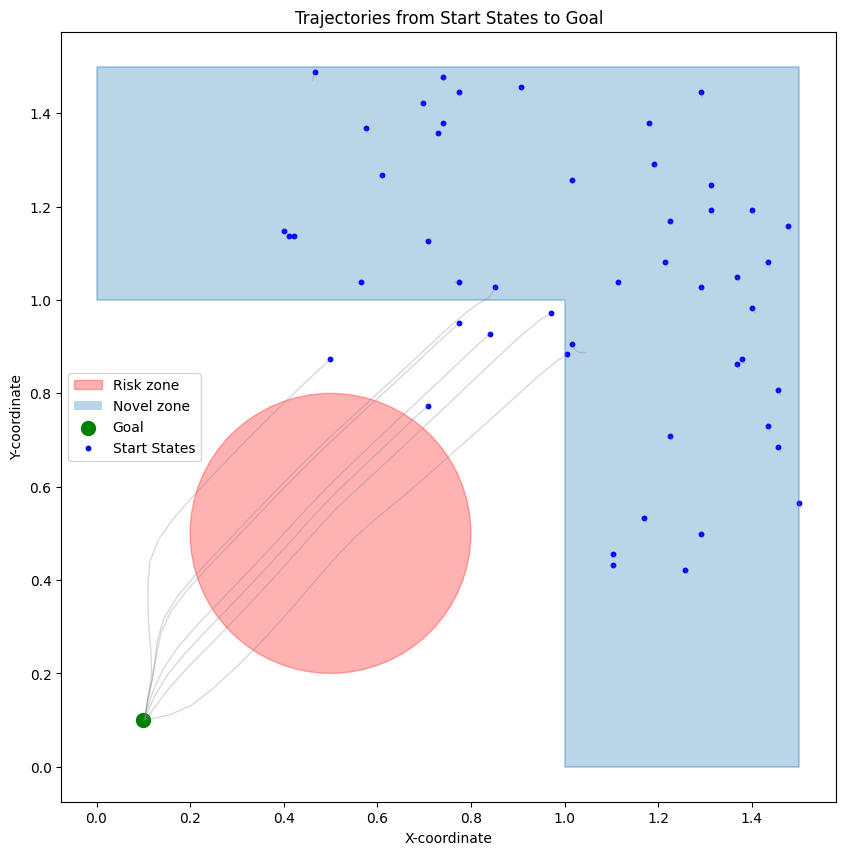

In [ ]:
plot_trajectories(student)

### Q values of learned suboptimal policy using MC returns

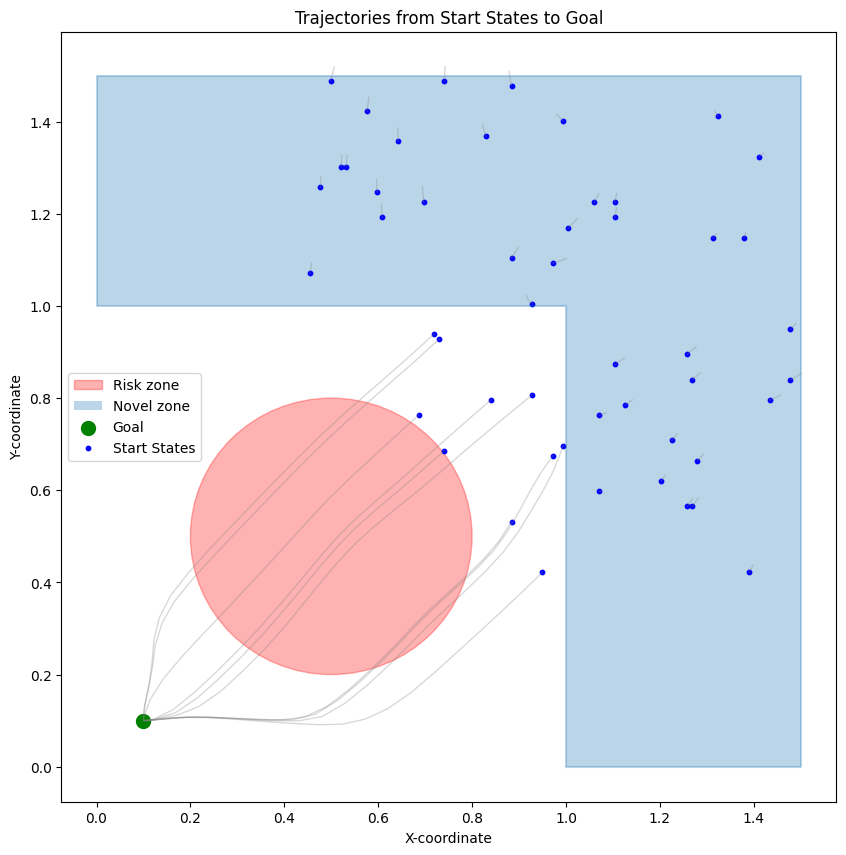

In [14]:
student_path = "/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen100_hs1.5/imitation/0/240115-121823/with_critic.pth"
student.load_state_dict(torch.load(student_path))
plot_trajectories(student)

In [15]:
def add_returns(buffer: ReplayBuffer) -> ReplayBuffer:
    data_dict = buffer._meta.__dict__
    start_idx = np.concatenate([np.array([0]), np.where(data_dict["done"])[0] + 1])
    end_idx = np.concatenate(
        [np.where(data_dict["done"])[0] + 1, np.array([len(data_dict["done"])])]
    )
    ep_rew = [data_dict["rew"][i:j] for i, j in zip(start_idx, end_idx)]
    ep_ret = []
    for i in range(len(ep_rew)):
        episode_rewards = ep_rew[i]
        disc_returns = [0] * len(episode_rewards)
        discounted_return = 0
        for j in range(1, len(episode_rewards) + 1):
            discounted_return = (
                episode_rewards[len(episode_rewards) - j] + gamma * discounted_return
            )
            disc_returns[len(episode_rewards) - j] = discounted_return
        ep_ret.append(disc_returns)

    new_data_dict = data_dict.copy()
    ep_rets = np.concatenate(ep_ret)
    new_data_dict["mc_returns"] = ep_rets
    new_batch = Batch(**new_data_dict)
    buffer._meta = new_batch
    return buffer

In [18]:
subopt_buffer = VectorReplayBuffer(buffer_size, 100)
subopt_collector = Collector(student, train_envs, subopt_buffer)

In [ ]:
subopt_collector.collect(n_episode=5000)

In [ ]:
subopt_buffer = add_returns(subopt_buffer)

In [ ]:
net_c = Net(
    state_shape,
    action_shape,
    hidden_sizes=hidden_sizes,
    concat=True,
    device=device,
    norm_layer=nn.LayerNorm
)
critic = Critic(net_c, device=device).to(device)
critic_optim = torch.optim.Adam(critic.parameters(), lr=critic_lr)

In [ ]:
losses = []
for _ in range(10000):
    batch, _ = subopt_buffer.sample(batch_size)
    batch = to_torch(batch, dtype=torch.float32, device=device)
    critic_optim.zero_grad()
    pred = critic(batch.obs, batch.act)
    loss = torch.mean((pred.squeeze() - batch.mc_returns) ** 2)
    loss.backward()
    critic_optim.step()
    losses.append(loss.item())

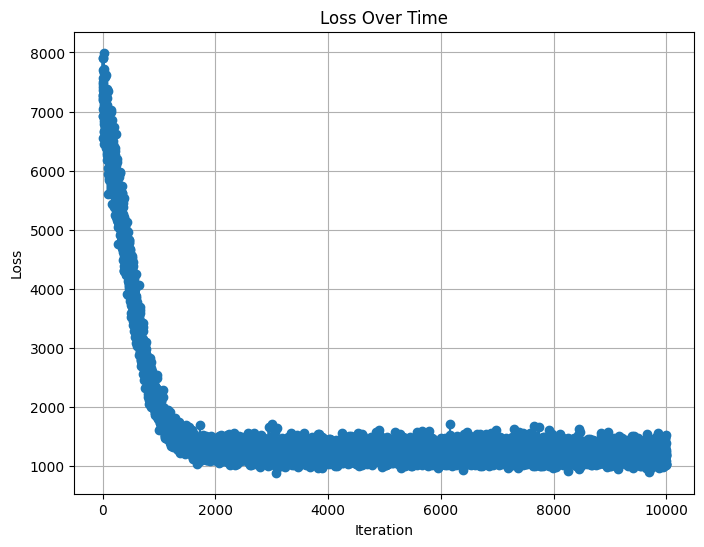

In [234]:
plt.figure(figsize=(8, 6))
plt.plot(losses, marker='o', linestyle='-')
plt.title('Loss Over Time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [235]:
student.critic1.load_state_dict(critic.state_dict())
student.critic2.load_state_dict(critic.state_dict())
student.critic1_old.load_state_dict(critic.state_dict())
student.critic2_old.load_state_dict(critic.state_dict())

<All keys matched successfully>

In [208]:
# save student with critic:
directory, file_extension = os.path.split(student_path)
torch.save(student.state_dict(), os.path.join(directory, "with_critic.pth"))

### Q values for safe policy using MC returns

Loaded agent from:  /data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20_hs1.5/dsac/wang0.75/0/240111-114541/policy.pth


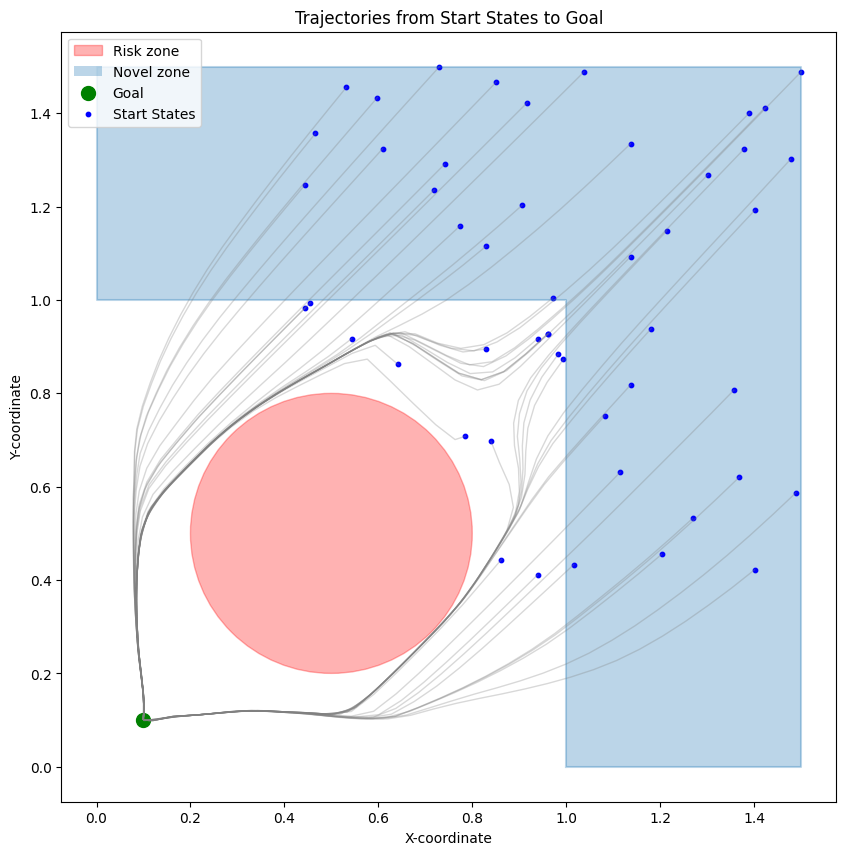

In [20]:
safe_policy_path = "/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20_hs1.5/dsac/wang0.75/0/240111-114541/policy.pth"
safe_policy = load_policy(safe_policy_path)
plot_trajectories(safe_policy)

In [21]:
safe_buffer = VectorReplayBuffer(buffer_size, 100)
safe_collector = Collector(safe_policy, train_envs, safe_buffer)

In [22]:
safe_collector.collect(n_episode=5000)

{'n/ep': 5000,
 'n/st': 110216,
 'rews': array([ -0.59748399,  -7.32116421, -11.89600284, ..., -15.33092257,
        -14.85620494, -15.95564203]),
 'lens': array([ 7, 17, 22, ..., 24, 25, 25]),
 'idxs': array([70000, 50000, 10000, ..., 21002, 51008, 81009]),
 'rew': -13.536795643786128,
 'len': 22.0432,
 'rew_std': 7.833185183172081,
 'len_std': 7.685163222729885}

In [23]:
safe_buffer = add_returns(safe_buffer)

In [24]:
net_c = Net(
    state_shape,
    action_shape,
    hidden_sizes=hidden_sizes,
    concat=True,
    device=device,
    norm_layer=nn.LayerNorm
)
critic = Critic(net_c, device=device).to(device)
critic_optim = torch.optim.Adam(critic.parameters(), lr=critic_lr)

In [25]:
losses = []
for _ in range(10000):
    batch, _ = safe_buffer.sample(batch_size)
    batch = to_torch(batch, dtype=torch.float32, device=device)
    critic_optim.zero_grad()
    pred = critic(batch.obs, batch.act)
    target = batch.mc_returns
    loss = torch.mean((pred.squeeze() - target) ** 2)
    loss.backward()
    critic_optim.step()
    losses.append(loss.item())

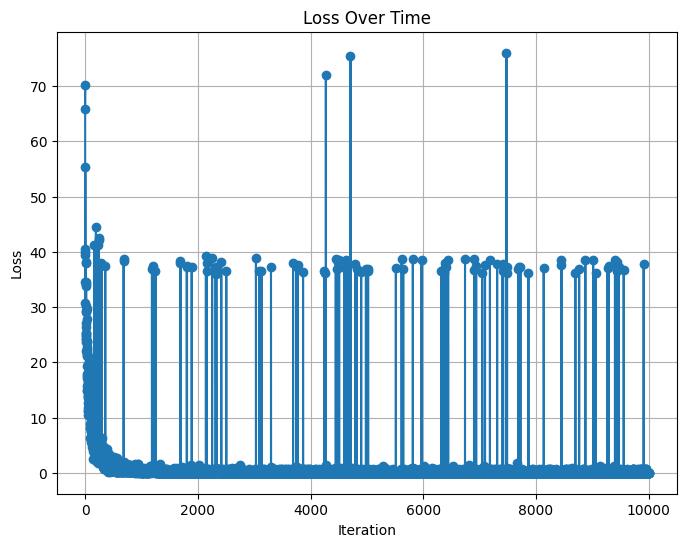

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(losses, marker='o', linestyle='-')
plt.title('Loss Over Time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [28]:
# update the critic of the safe policy
safe_policy.critic1 = deepcopy(critic)

### Plotting the Q-values

In [47]:
x = np.linspace(0, 1.5, num=100)
y = np.linspace(0, 1.5, num=100) 
X, Y = np.meshgrid(x, y)
states =  np.vstack([X.ravel(), Y.ravel()]).T

batch = Batch(obs=torch.from_numpy(states).to(dtype=torch.float32, device=device), info={})
with torch.no_grad():
    safe_result = safe_policy(batch)
    q_safe = safe_policy.critic1(batch.obs, safe_result.act)
    student_result = student(batch)
    q_subopt = student.critic2(batch.obs, student_result.act)

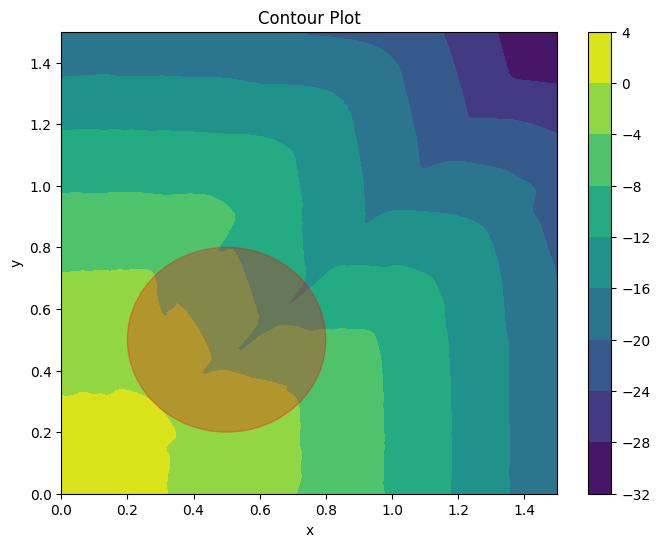

In [30]:
# Create contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, q_safe.cpu().numpy().reshape(100, 100), cmap='viridis')
# Plot the risk area
circle = plt.Circle((0.5, 0.5), 0.3, color='red', alpha=0.3, label="Risk zone")
plt.gca().add_patch(circle)
plt.colorbar(contour)
plt.title('Contour Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

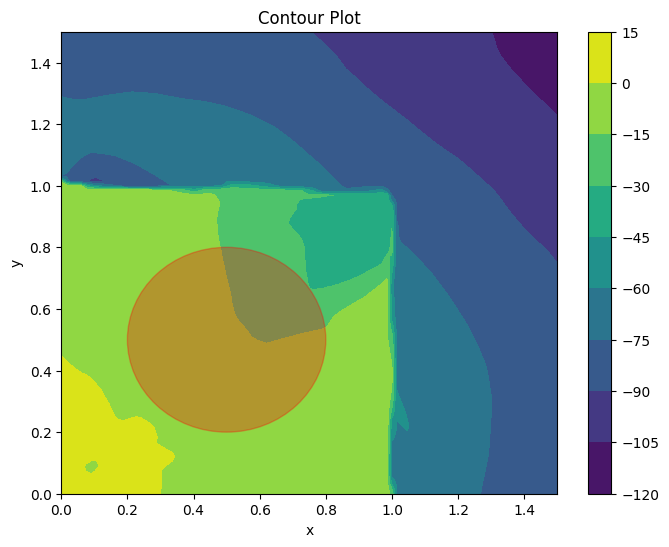

In [48]:
# Create contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, q_subopt.cpu().numpy().reshape(100, 100), cmap='viridis')
# Plot the risk area
circle = plt.Circle((0.5, 0.5), 0.3, color='red', alpha=0.3, label="Risk zone")
plt.gca().add_patch(circle)
plt.colorbar(contour)
plt.title('Contour Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

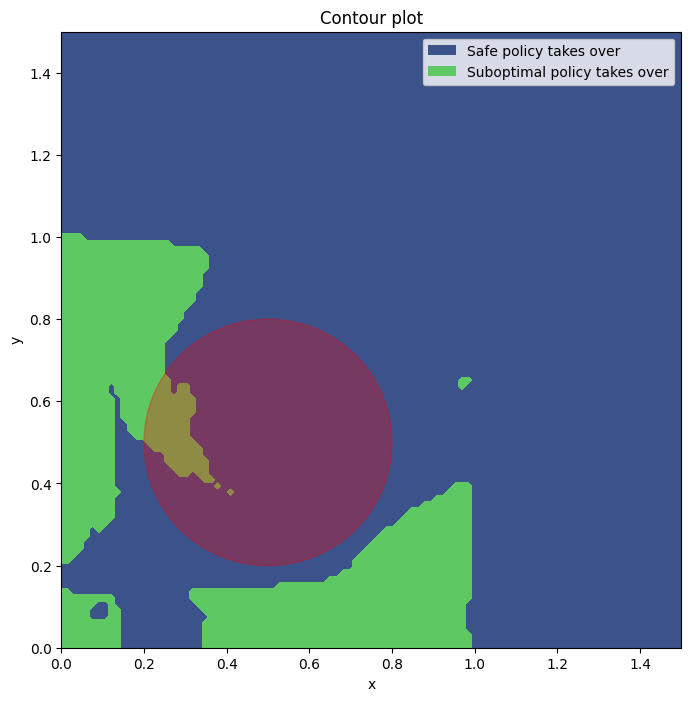

In [32]:
z_subopt = q_subopt.cpu().numpy().reshape(100, 100)
z_safe = q_safe.cpu().numpy().reshape(100, 100)

plt.figure(figsize=(8, 8))
contour = plt.contourf(X, Y, z_subopt - z_safe > 0, cmap='viridis', levels=[0, 0.5, 1])
# Plot the risk area
circle = plt.Circle((0.5, 0.5), 0.3, color='red', alpha=0.3, label="Risk zone")
plt.gca().add_patch(circle)
# Create custom legend labels
legend_labels = {0: "Safe policy takes over", 1: "Suboptimal policy takes over"}
# Add legend with custom labels
handles, _ = contour.legend_elements()
plt.legend(handles, [legend_labels[i] for i in range(2)])

plt.title('Contour plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

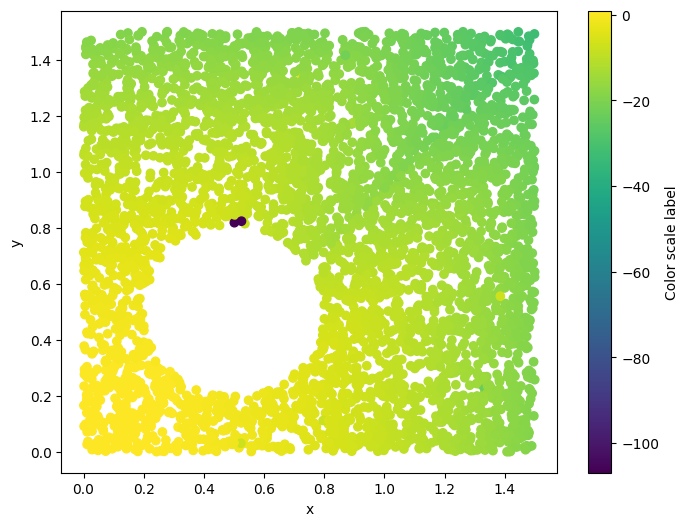

In [155]:
start_idx = np.concatenate([np.array([0]), np.where(safe_buffer.done)[0] + 1])
start_batch = safe_buffer[start_idx]
X = start_batch.obs[:, 0]
Y = start_batch.obs[:, 1]
Z = start_batch.mc_returns
# Create contour plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X, Y, c=Z, cmap='viridis')
plt.colorbar(scatter, label='Color scale label')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

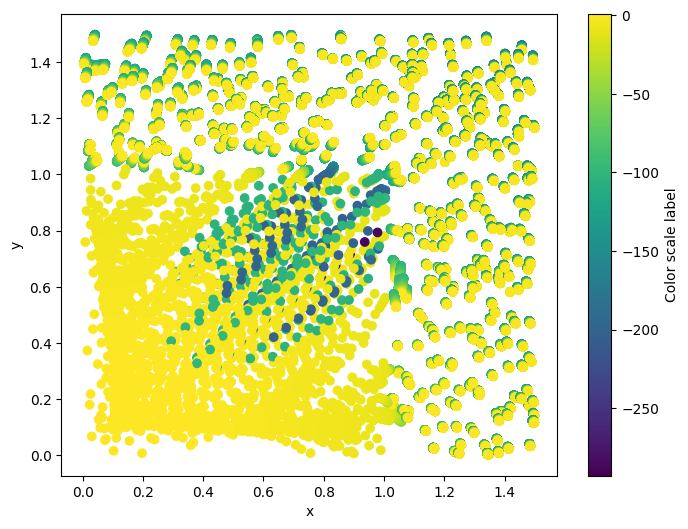

In [239]:
batch, _ = subopt_buffer.sample(0)
X = batch.obs[:, 0]
Y = batch.obs[:, 1]
Z = batch.mc_returns
# Create contour plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X, Y, c=Z, cmap='viridis')
plt.colorbar(scatter, label='Color scale label')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Analyse the returns of the safe policy and the suboptimal policy with initial state around (0.95, 0.95)

In [33]:
def get_returns(policy, n=500, rnd=True, return_cede_ctrl=False):
    policy.eval()
    returns = []
    cede_ctrl = []
    for _ in range(n):
        obs, info = env.reset(init_state=np.array([0.95, 0.95])+(np.random.uniform(-0.05, 0.05, 2)*float(rnd)))
        done = False
        cum_reward = 0
        actions = []
        if return_cede_ctrl:
            cctrl_ep = []
        while not done:
            batch = Batch(obs=torch.from_numpy(np.expand_dims(obs, 0)).to(device), info=info)
            with torch.no_grad():
                result = policy(batch)
            act = result.act.cpu().squeeze().numpy()
            act = policy.map_action(act)
            if return_cede_ctrl:
                cctrl_ep.append(result.policy.cede_ctrl.cpu().squeeze().numpy())
            obs, reward, terminated, truncated, info = env.step(act)
            actions.append(act)
            cum_reward += reward
            done = terminated or truncated
        returns.append(cum_reward)
        if return_cede_ctrl:
            cede_ctrl.append(np.array(cctrl_ep).mean())
    if return_cede_ctrl:
        return np.array(returns),  np.array(cede_ctrl).mean()
    return np.array(returns)

In [34]:
safe_returns = get_returns(safe_policy)
subopt_returns = get_returns(student)

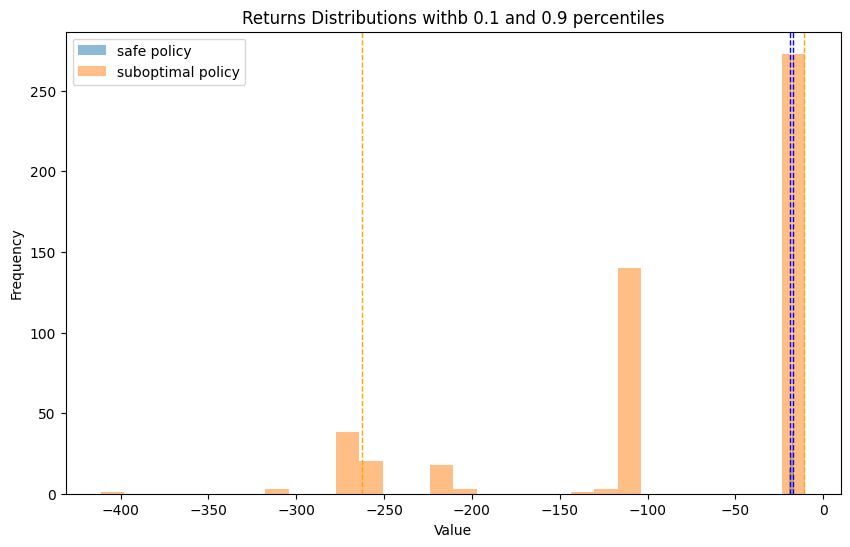

In [35]:
percentile_10_safe = np.percentile(safe_returns, 10)
percentile_90_safe = np.percentile(safe_returns, 90)
percentile_10_subopt = np.percentile(subopt_returns, 10)
percentile_90_subopt = np.percentile(subopt_returns, 90)

plt.figure(figsize=(10, 6))
plt.hist(safe_returns, bins=30, alpha=0.5, label='safe policy')
plt.hist(subopt_returns, bins=30, alpha=0.5, label='suboptimal policy')
plt.axvline(percentile_10_safe, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(percentile_90_safe, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(percentile_10_subopt, color='orange', linestyle='dashed', linewidth=1)
plt.axvline(percentile_90_subopt, color='orange', linestyle='dashed', linewidth=1)

# Adding titles and labels
plt.title('Returns Distributions withb 0.1 and 0.9 percentiles')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

### Improve suboptimal policy safely (taking actions with the mixed policy)

In [36]:
class MixedPolicy(BasePolicy):
    def __init__(self, subopt_policy: BasePolicy, safe_policy: BasePolicy, action_space):
        super().__init__(action_space=action_space, action_scaling=True)
        self.subopt_policy = subopt_policy
        self.safe_policy = safe_policy

    def forward(self, batch: RolloutBatchProtocol, state=None, **kwargs):
        batch = to_torch(batch, dtype=torch.float32, device=device)
        self.subopt_policy.eval()
        self.safe_policy.eval()
        with torch.no_grad():
            safe_result = self.safe_policy(batch)
            subopt_result = self.subopt_policy(batch)
            expert_qvalues = self.safe_policy.critic1(batch.obs, safe_result.act)
            base_qvalues = self.subopt_policy.critic1(batch.obs, subopt_result.act)
        cede_ctrl = base_qvalues[:, 0] < expert_qvalues[:, 0]
        cede_ctrl = cede_ctrl.unsqueeze(-1)
        actions = torch.where(cede_ctrl, safe_result.act, subopt_result.act)
        return Batch(**{'act': actions, 'policy': Batch({'cede_ctrl': cede_ctrl})})

    def train(self, mode: bool = True) -> "MixedPolicy":
        self.subopt_policy.train(mode)
        return self
    
    def process_fn(self, batch: RolloutBatchProtocol, buffer: ReplayBuffer, indices: np.ndarray) -> RolloutBatchProtocol:
        return self.subopt_policy.process_fn(batch, buffer, indices)

    def learn(self, batch, **kwargs):
        cede_ctrl = batch.policy.cede_ctrl.cpu().squeeze()
        batch = batch[~cede_ctrl]
        info = self.subopt_policy.learn(batch)
        return info

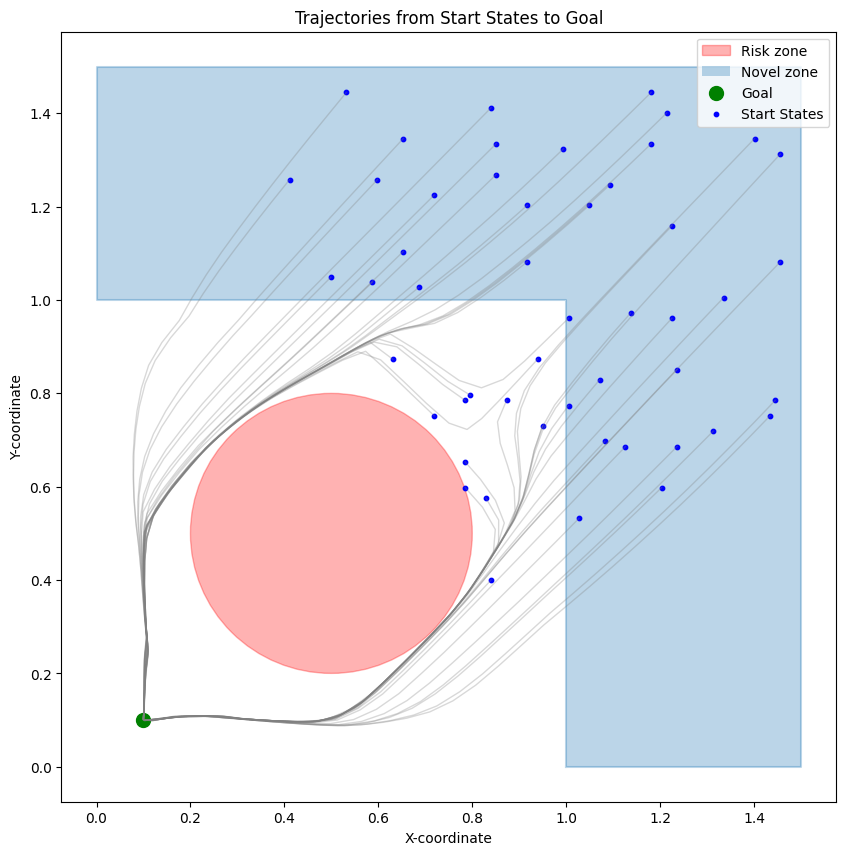

In [37]:
student.mode = "sac"
student._alpha = 0.02
student._is_auto_alpha = False
mixed_policy = MixedPolicy(student, safe_policy, env.action_space)
plot_trajectories(mixed_policy)

In [49]:
# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
algo_name = "mixed"
log_name = os.path.join(task+f"_prob{risk_prob}"+f"_pen{risk_penalty}"+f"_hs{high_state}", algo_name, str(seed), now)
log_path = os.path.join(logdir, log_name)
print(f"log path: {log_path}")

# logger
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

log path: log/PointMass_prob0.95_pen100_hs1.5/mixed/0/240117-122836


In [50]:
def save_best_fn(policy):
    torch.save(policy.state_dict(), os.path.join(log_path, "best.pth"))


def test_fn(num_epoch: int, step_idx: int):
    returns, cede_ctrl = get_returns(mixed_policy, 50, False, True)
    percentile_10 = np.percentile(returns, 10)
    print(percentile_10, cede_ctrl)

In [51]:
buffer = VectorReplayBuffer(1000000, training_num)
train_collector = Collector(student, train_envs, buffer)
test_buffer = VectorReplayBuffer(1000*test_num, test_num)
test_collector = Collector(student, test_envs, test_buffer)

In [52]:
result = OffpolicyTrainer(
    policy=student,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=epoch,
    step_per_epoch=step_per_epoch,
    step_per_collect=step_per_collect,
    episode_per_test=test_num,
    batch_size=batch_size,
    save_best_fn=save_best_fn,
    test_fn=test_fn,
    logger=logger,
    update_per_step=update_per_step,
    test_in_train=False,
).run()
pprint.pprint(result)

-18.0880788192631 0.7407407407407406


Epoch #1:   0%|          | 0/500 [00:00<?, ?it/s]/data/user/R901105/dev/my_fork/tianshou/tianshou/data/collector.py:241: UserWarning: n_step=1 is not a multiple of #env (10), which may cause extra transitions collected into the buffer.
  warnings.warn(
Epoch #1: 501it [00:07, 69.45it/s, env_step=500, gradient_step=500, len=0, loss/actor=0.924, loss/critic1=0.342, loss/critic2=0.342, n/ep=0, n/st=10, rew=0.00]                              


-242.88255003093275 0.2222222222222222
Epoch #1: test_reward: -266.951176 ± 0.000000, best_reward: -107.685442 ± 0.000000 in #0


Epoch #2: 501it [00:07, 69.53it/s, env_step=1000, gradient_step=1000, len=0, loss/actor=1.978, loss/critic1=58.356, loss/critic2=58.356, n/ep=0, n/st=10, rew=0.00]                         


-110.5727012716542 0.33333333333333326
Epoch #2: test_reward: -1013.703664 ± 0.000000, best_reward: -107.685442 ± 0.000000 in #0


Epoch #3: 501it [00:07, 68.86it/s, env_step=1500, gradient_step=1500, len=0, loss/actor=2.502, loss/critic1=73.900, loss/critic2=73.900, n/ep=0, n/st=10, rew=0.00]                         


-112.61567372435594 0.33333333333333326
Epoch #3: test_reward: -167.700068 ± 0.000000, best_reward: -107.685442 ± 0.000000 in #0


Epoch #4: 501it [00:07, 70.64it/s, env_step=2000, gradient_step=2000, len=200, loss/actor=1.829, loss/critic1=49.029, loss/critic2=49.029, n/ep=10, n/st=10, rew=-250.99]                         


-123.39419182692232 0.4782608695652174
Epoch #4: test_reward: -101.964253 ± 0.000000, best_reward: -101.964253 ± 0.000000 in #4


Epoch #5: 501it [00:07, 67.51it/s, env_step=2500, gradient_step=2500, len=2, loss/actor=2.368, loss/critic1=35.835, loss/critic2=35.835, n/ep=0, n/st=10, rew=0.77]                              


-113.46595006760421 0.391304347826087
Epoch #5: test_reward: -146.591703 ± 0.000000, best_reward: -101.964253 ± 0.000000 in #4


Epoch #6: 501it [00:07, 70.16it/s, env_step=3000, gradient_step=3000, len=2, loss/actor=3.460, loss/critic1=27.576, loss/critic2=27.576, n/ep=0, n/st=10, rew=0.77]                         


-110.99445843580723 0.3684210526315789
Epoch #6: test_reward: -114.023551 ± 0.000000, best_reward: -101.964253 ± 0.000000 in #4


Epoch #7: 501it [00:06, 71.74it/s, env_step=3500, gradient_step=3500, len=2, loss/actor=3.986, loss/critic1=22.990, loss/critic2=22.990, n/ep=0, n/st=10, rew=0.77]                         


-122.70963419979775 0.4782608695652174
Epoch #7: test_reward: -120.506889 ± 0.000000, best_reward: -101.964253 ± 0.000000 in #4


Epoch #8: 501it [00:07, 70.71it/s, env_step=4000, gradient_step=4000, len=200, loss/actor=4.507, loss/critic1=22.242, loss/critic2=22.242, n/ep=7, n/st=10, rew=-87.41]                         


-113.88589980721184 0.52
Epoch #8: test_reward: -30.116586 ± 0.000000, best_reward: -30.116586 ± 0.000000 in #8


Epoch #9: 501it [00:06, 74.11it/s, env_step=4500, gradient_step=4500, len=200, loss/actor=4.656, loss/critic1=17.194, loss/critic2=17.194, n/ep=0, n/st=10, rew=-94.79]                         


-118.15785742631164 0.3076923076923077
Epoch #9: test_reward: -96.212034 ± 0.000000, best_reward: -30.116586 ± 0.000000 in #8


Epoch #10: 501it [00:06, 71.75it/s, env_step=5000, gradient_step=5000, len=200, loss/actor=4.852, loss/critic1=13.684, loss/critic2=13.684, n/ep=0, n/st=10, rew=-94.79]                         


-223.45350637346792 0.33333333333333326
Epoch #10: test_reward: -81.817227 ± 0.000000, best_reward: -30.116586 ± 0.000000 in #8


Epoch #11: 501it [00:07, 71.06it/s, env_step=5500, gradient_step=5500, len=160, loss/actor=5.077, loss/critic1=15.104, loss/critic2=15.104, n/ep=0, n/st=10, rew=-31.83]                         


-124.98592742857122 0.30434782608695654
Epoch #11: test_reward: -489.311761 ± 0.000000, best_reward: -30.116586 ± 0.000000 in #8


Epoch #12: 501it [00:06, 71.83it/s, env_step=6000, gradient_step=6000, len=200, loss/actor=5.378, loss/critic1=14.395, loss/critic2=14.395, n/ep=7, n/st=10, rew=-156.33]                         


-1336.1167250639803 0.145
Epoch #12: test_reward: -620.579152 ± 0.000000, best_reward: -30.116586 ± 0.000000 in #8


Epoch #13: 501it [00:07, 69.59it/s, env_step=6500, gradient_step=6500, len=200, loss/actor=5.422, loss/critic1=27.225, loss/critic2=27.225, n/ep=0, n/st=10, rew=-75.61]                          


-1573.8392389404194 0.085
Epoch #13: test_reward: -947.170304 ± 0.000000, best_reward: -30.116586 ± 0.000000 in #8


Epoch #14: 501it [00:07, 68.01it/s, env_step=7000, gradient_step=7000, len=200, loss/actor=5.092, loss/critic1=57.184, loss/critic2=57.184, n/ep=0, n/st=10, rew=-75.61]                         


-202.2345591624283 0.21000000000000005
Epoch #14: test_reward: -922.596501 ± 0.000000, best_reward: -30.116586 ± 0.000000 in #8


Epoch #15:   4%|4         | 20/500 [00:00<00:06, 69.72it/s, env_step=7010, gradient_step=7010, len=200, loss/actor=5.126, loss/critic1=59.885, loss/critic2=59.885, n/ep=0, n/st=10, rew=-75.61] 


KeyboardInterrupt: 

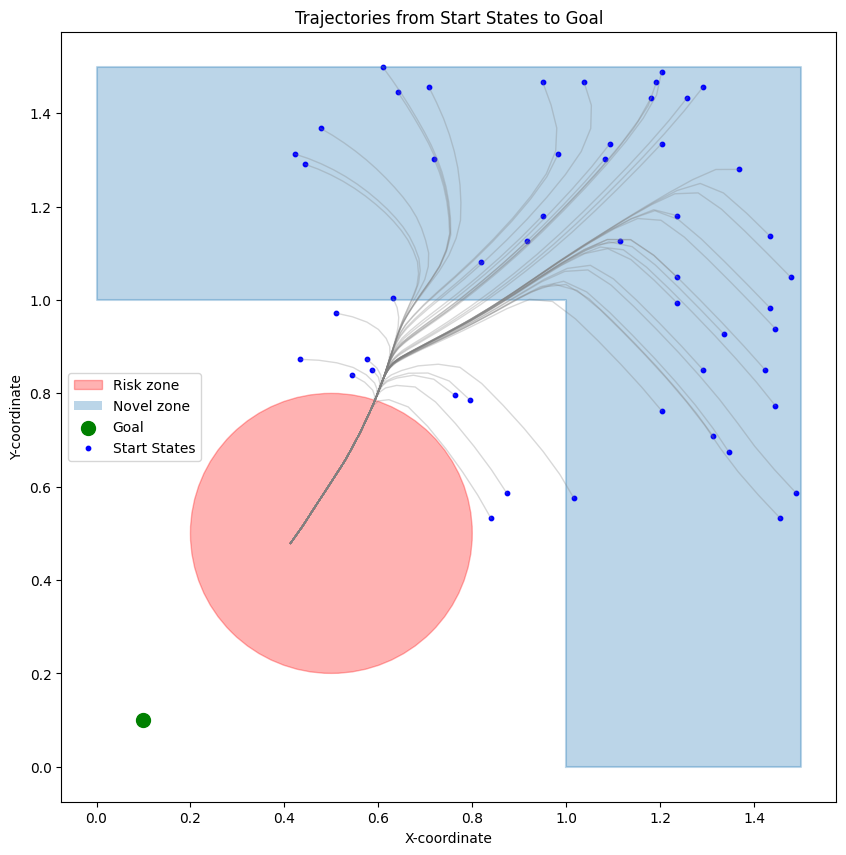

In [53]:
plot_trajectories(student)